# Certamen de Simulación Estocástica - Pregunta 1
- Diego Astaburuaga

Considerando matrices simétricas de dimensión $p\times p$ con valores propios positivos, notamos que se busca simular desde la distribución de Wishart.

En efecto, la distribución de Wishart es una familia de distribuciones para matrices simetricas definidas positivas.

Sean $Z_1,...,Z_k$ independientes desde una distribución $N_p(0,\Sigma)$, entonces escriba la matriz
$$
Z=
\begin{pmatrix}
Z_1^T\\
Z_2^T\\
\vdots\\
Z_k^T
\end{pmatrix}
$$
de dimensión $k\times p$. La matriz de dimensión $p\times p$ aleatoria $X=Z^TZ=\sum_{i=1}^kZ_iZ_i^T$ se dice que sigue una distribución de Wishart.

**Definición 1.** La matriz aleatoria $X_{(p\times p)}=\sum_{i=1}^kZ_iZ_i^T$ tiene una distribución de Wishart con $k$ grados de libertad y matriz de covarianza $\Sigma$ y se denota $X\sim W_p(n,\Sigma)$. Para $k> p-1$ la densidad de probabilidad de $M$ está dada por
$$
f(X)=\frac{\det(X)^{(k-p-1)/2}}{2^{kp/2}\Gamma_p(k/2)\det(\Sigma)^{k/2}}\exp\left(-\frac{1}{2} Tr(\Sigma^{-1}X)\right)
$$
para $X$ en las matrices simetricas definidas positivas.

Note que la notación para la matriz $V=\Sigma$ es consistente al ser una matriz de covarianza, ya que siempre puede ser tomada como simetrica y definida positiva (basta con no utilizar aquellas singulares).

## 1) Método de simulación.

Se escoje el método de simulación directo que surge de utilizar la definición de la distribución que se está considerando, esto es:

i) Generar y fijar $\Sigma$ matriz $p\times p$ simetrica y definida positiva.

ii) Simular de forma independiente $Z_1,...,Z_k$ desde una distribución $N_p(0,\Sigma)$.

iii) Calcular $X=\sum_{i=1}^kZ_iZ_i^T$.

Además se tiene que si $|\Sigma|>0$, entonces $|X|>0$ con probabilidad 1 (Análisis multivariado, Osorio). Desde esto se propone simular $Z_1,\dots,Z_k$ vectores aleatorios desde $N_p(0,\Sigma)$ para $\Sigma$ no singular.

Dado que solamente podemos simular desde distribuciones univariadas, ocuparemos el siguiente razonamiento:

1) Simulamos $p$ valores desde una distribución $N(0,1)$ y los agrupamos en un array Y para obtener una simulación desde $N_p(0,I)$ con $I$ la identidad.
2) Calculamos $Z=BY$ para $B$ dada por $\Sigma=BB^T$ y obtenemos $Z\sim N_p(0,\Sigma)$ (Análisis de regresión, Osorio).

Ahora considere el siguiente procedimiento:
$$
X = \sum_{i=1}^kZ_iZ_i^T=\sum_{i=1}^kBY_iY_i^TB^T=B\left(\sum_{i=1}^kY_iY_i^T\right)B^T
$$

para $Y_1,\dots,Y_k$ desde $N_p(0,I)$. De esta forma obtenemos que $X\sim W_p(k,\Sigma)$ la cual corresponde a nuestra distribución objetivo (Análisis Multivariado, Osorio).

Considere el siguiente resultado: Si $\Sigma>0$ y $k> p-1$ entonces $X>0$ con probabilidad 1 (Análisis Multivariado, Osorio), de esta estaremos simulando matrices $X$, simetricas y definidas positivas.

Ahora para obtener $B$, basta con simular $\Sigma>0$ y luego, para cualquier $\Sigma>0$ (definida positiva) podemos aplicar factorización Cholesky para obtener $\Sigma = B B^T$.

**Hasta este punto** se tiene la capacidad de generar un distribución Wishart para $k$ grados de libertad enteros, ahora, sea $k$ un grado de libertad real tal que $k>-1$.

Sea $g$ la distribución instrumental a utilizar dada por:
$$
g(X) = \det(X)^{(k'-p-1)/2}\exp\left(-\frac{1}{2} Tr(\Sigma^{-1}X)\right)
$$
con $k'$ el entero mayor más cercano a $k$, luego se desea simular desde:
$$
h(X) = \det(X)^{(k-p-1)/2}\exp\left(-\frac{1}{2} Tr(\Sigma^{-1}X)\right)
$$
donde es necesario entender el cuociente $h/g$:
$$
\frac{h(X)}{g(X)} = \det(X)^{(k-k')/2}
$$

Mediante simulación exhaustiva se puede calcular una cota para el determinante de $X$ que se verifique para una gran mayoría de casos, por ejemplo, realizar $10\.000$ simulaciones de $X$ desde la instrumental, se puede calcular el determinante elevado a la potencia descrita y obtener una cota como el mayor valor de todos ellos. Denotando dicha cota como $M$, tendríamos que
$$
\frac{h(X)}{Mg(X)}\leq 1
$$

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [20]:
def generate_covariance_matrix(p=1):
    while True:
        # Generate a random p x p matrix with values between 0 and 1
        B = np.random.rand(p, p)

        # Calculate the covariance matrix
        Sigma = B @ B.T

        # Check if the covariance matrix is positive definite
        if is_positive_definite(Sigma):
            return Sigma

def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

# Example of usage
p_dimension = 3  # Replace with the desired dimension
cov_matrix = generate_covariance_matrix(p_dimension)

print("Covariance Matrix Sigma:")
print(cov_matrix)

print("Es definida positiva:")
print(is_positive_definite(cov_matrix))

Covariance Matrix Sigma:
[[1.06986635 0.67441546 1.44342041]
 [0.67441546 0.56168762 1.0620291 ]
 [1.44342041 1.0620291  2.12112556]]
Es definida positiva:
True


In [21]:
def simulate_wishart_distribution_int(p, k=None, Sigma=None):
    # Verifica si no se proporcionó una matriz B, en cuyo caso se utiliza la matriz identidad por defecto
    if Sigma is None:
        Sigma = np.identity(p)

    # Verifica si no se proporcionó el número de grados de libertad k, en cuyo caso se utiliza k = p por defecto
    if k is None:
        k = p

    # Calcula la factorización Cholesky
    B = np.linalg.cholesky(Sigma)

    # Inicializa una matriz X de ceros de tamaño (p, p) para acumular los productos
    X = np.zeros((p, p))

    # Itera k veces para simular los grados de libertad de la distribución Wishart
    for _ in range(k):
        # Genera p números aleatorios de una distribución normal estándar con media 0 y desviación estándar 1
        Y = np.random.normal(0, 1, p)

        X += np.outer(Y, Y)

    # Escala la matriz resultante según la matriz de escala B
    X = B @ X @ B.T

    # Devuelve la matriz resultante que sigue una distribución Wishart
    return X


# Example of usage
p_dimension = 3  # Dimension of the random vectors
num_vectors = 5  # Number of random vectors to simulate

# Simulate random vectors with a custom covariance matrix
Sigma= generate_covariance_matrix(p_dimension)
simulated_data_custom = simulate_wishart_distribution_int(p_dimension, num_vectors, Sigma = Sigma)
print("Simulated Data from wishart distribution:")
print(simulated_data_custom)

Simulated Data from wishart distribution:
[[0.59859072 0.78875462 0.7798739 ]
 [0.78875462 1.2760176  1.00455707]
 [0.7798739  1.00455707 1.48030244]]


In [22]:
import numpy as np
import math

def find_M(p, k, Sigma, n_samples=100):
    """
    Encuentra el valor M para la distribución instrumental g.

    Args:
        p (int): Dimensión de la matriz Wishart.
        k (float): Grados de libertad.
        Sigma (numpy.ndarray): Matriz de covarianza.
        n_samples (int): Número de muestras para estimar M.

    Returns:
        float: Valor de M para la distribución g.
    """
    M = []
    _, kk = math.modf(k)
    kk = int(kk + 1)
    for _ in range(n_samples):
        X = simulate_wishart_distribution_int(p, kk, Sigma)
        M.append(np.linalg.det(X) ** ((k - kk) / 2))
    M = np.max(M)
    return M

def simulate_wishart_distribution(p, k=None, Sigma=None, M=None):
    """
    Simula una matriz de la distribución Wishart.

    Args:
        p (int): Dimensión de la matriz Wishart.
        k (float): Grados de libertad.
        Sigma (numpy.ndarray): Matriz de covarianza.
        M (float): Valor M para la distribución instrumental g.

    Returns:
        numpy.ndarray: Muestra de la distribución Wishart.
    """
    if Sigma is None:
        Sigma = np.identity(p)

    # Verifica si no se proporcionó el número de grados de libertad k, en cuyo caso se utiliza k = p por defecto
    if k is None:
        k = p

    if M is None:
        M = find_M(p, k, Sigma)

    _, kk = math.modf(k)
    kk = int(kk + 1)

    itr_max_intern = 1_000

    itr_actual_intern = 0
    while True:
        itr_actual_intern += 1
        if itr_actual_intern == itr_max_intern: return print(f'itr_max_intern alcanced.')
        X = simulate_wishart_distribution_int(p, kk, Sigma)
        U = np.random.uniform(0,1)
        if U <= np.linalg.det(X) ** ((k - kk) / 2)/M:
            return X, itr_actual_intern

# Ejemplo de uso
p = 3  # Dimensión de la matriz Wishart
k = 5  # Grados de libertad
Sigma = np.array([[1, 0.5, 0.2], [0.5, 2, 0.6], [0.2, 0.6, 0.8]])  # Matriz de covarianza

# Encuentra el valor M para la distribución instrumental g
M = find_M(p, k, Sigma)

# Simula una matriz desde la distribución Wishart
sample, rechazados = simulate_wishart_distribution(p, k, Sigma, M)

rechazados -= 1

print("Muestra de la distribución Wishart:")
print(sample)

print("Se rechazaron para llegar a este:")
print(rechazados)


Muestra de la distribución Wishart:
[[ 3.69817035  2.839175    0.52599482]
 [ 2.839175   22.34399519 10.64594592]
 [ 0.52599482 10.64594592  9.52491919]]


## 2) Gráficos relacionados a los tiempos de simulación respecto a la dimensión $p$.

In [24]:
# Crear una lista de valores de p
p_list = np.arange(10, 300+1, 10)

# Crear una lista de valores de k
k_list = np.linspace(0, 15, 4)

# Número de iteraciones para cada valor de p y k
n_itr = 100

# Diccionario para almacenar los tiempos de ejecución
time_by_p = {}

# Iterar a través de los valores de p en p_list
for p in p_list:
    time_by_k = {}  # Diccionario para los tiempos de ejecución por valor de k

    # Iterar a través de los valores de k en k_list
    for k in k_list:
        elapsed_times = []  # Lista para almacenar los tiempos de ejecución

        # Iniciar el contador de tiempo
        start_time = time.time()

        Sigma = generate_covariance_matrix(p)
        find_M(p, p + k, Sigma, n_samples=100)
        # Realizar n_itr simulaciones de Wishart para el valor actual de p y p+k
        for _ in range(n_itr):
            
            simulate_wishart_distribution(p, p + k, Sigma)

        # Detener el contador de tiempo y calcular el tiempo transcurrido
        end_time = time.time()
        elapsed_time = end_time - start_time

        elapsed_times.append(elapsed_time/n_itr)  # Agregar el tiempo transcurrido a la lista
        time_by_k[k] = elapsed_times  # Almacenar en el diccionario de tiempos por valor de k

    time_by_p[p] = time_by_k  # Almacenar en el diccionario de tiempos por valor de p

# El diccionario time_by_p ahora contiene los tiempos de ejecución para diferentes valores de p y k

KeyboardInterrupt: 

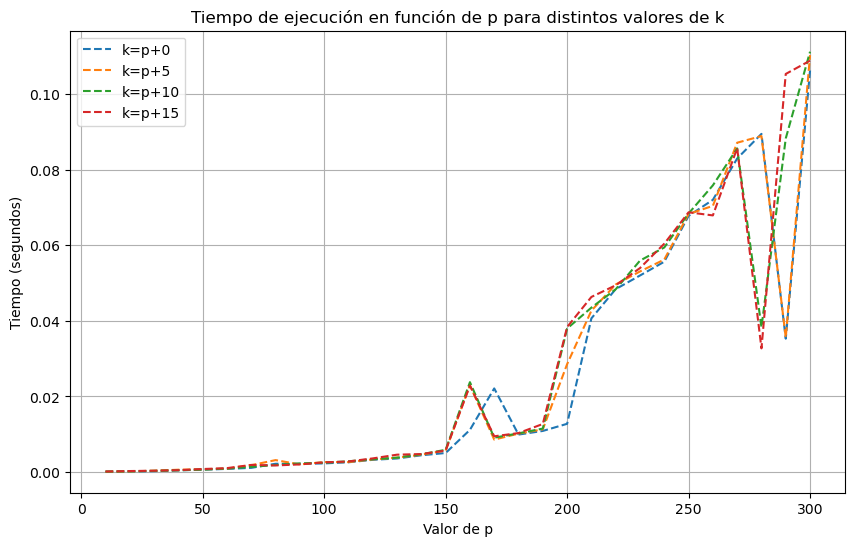

In [ ]:
# Crear el gráfico de tiempo vs. p para distintos valores de k
plt.figure(figsize=(10, 6))

for k in k_list:
    times = [time_by_p[p][k][0] for p in p_list]
    plt.plot(p_list, times, '--', label=f'k=p+{k}')

plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de ejecución en función de p para distintos valores de k')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [ ]:
# Iterar a través de los valores de p en p_list
elapsed_times = []  # Lista para almacenar los tiempos de ejecución
for p in p_list:

    # Iniciar el contador de tiempo
    start_time = time.time()

    # Realizar n_itr simulaciones de Wishart para el valor actual de p y p+k
    for _ in range(n_itr):
        # Generar una matriz de covarianza Sigma para p
        generate_covariance_matrix(p) 

    # Detener el contador de tiempo y calcular el tiempo transcurrido
    end_time = time.time()
    elapsed_time = end_time - start_time

    elapsed_times.append(elapsed_time/n_itr)  # Agregar el tiempo transcurrido a la lista

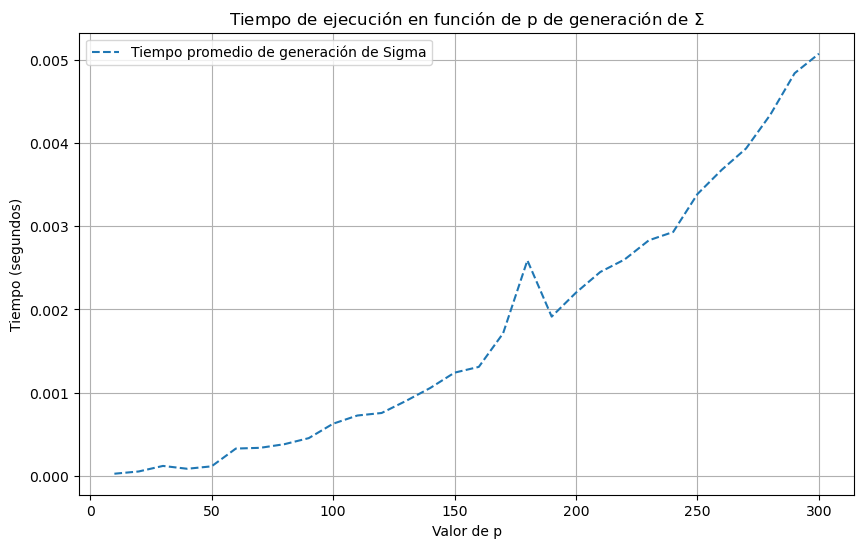

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(p_list, elapsed_times, '--', label=f'Tiempo promedio de generación de Sigma')


plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title(r'Tiempo de ejecución en función de p de generación de $\Sigma$')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

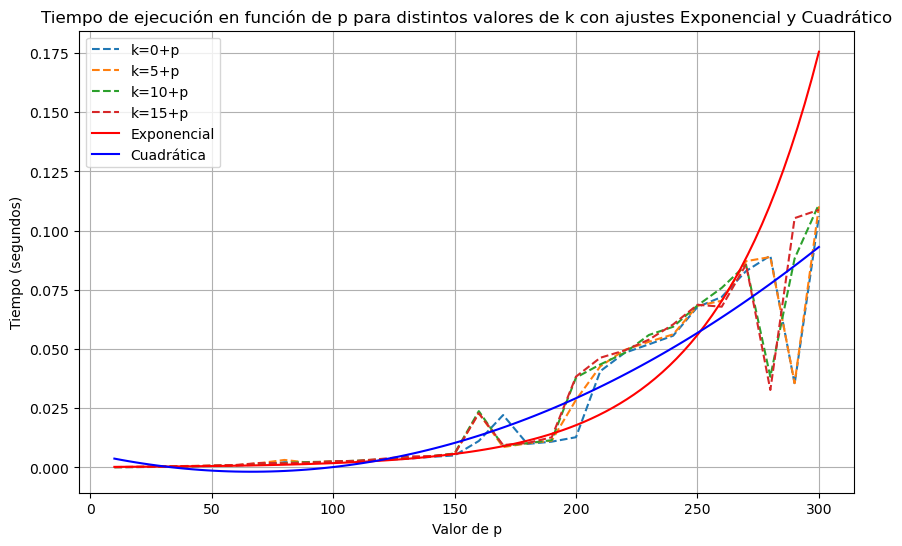

In [ ]:
# Crear el gráfico de tiempo vs. p para distintos valores de k
plt.figure(figsize=(10, 6))

for k in k_list:
    times = [time_by_p[p][k][0] for p in p_list]
    plt.plot(p_list, times, '--', label=f'k={k}+p')

# Ajustar una función exponencial para k=0
k_fit = 0
times_fit = [time_by_p[p][k_fit][0] for p in p_list]
params_exp, covariance_exp = np.polyfit(p_list, np.log(times_fit), 1, cov=True)
A_exp = np.exp(params_exp[1])
B_exp = params_exp[0]
fit_label_exp = f'Exponencial'

# Ajustar una función cuadrática para k=0
params_quad = np.polyfit(p_list, times_fit, 2)
A_quad = params_quad[0]
B_quad = params_quad[1]
C_quad = params_quad[2]
fit_label_quad = f'Cuadrática'

# Calcular las funciones ajustadas
p_values = np.linspace(min(p_list), max(p_list), 100)
times_exponential = A_exp * np.exp(B_exp * p_values)
times_quadratic = A_quad * p_values**2 + B_quad * p_values + C_quad

# Dibujar las funciones ajustadas
plt.plot(p_values, times_exponential, 'r-', label=fit_label_exp)
plt.plot(p_values, times_quadratic, 'b-', label=fit_label_quad)

plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de ejecución en función de p para distintos valores de k con ajustes Exponencial y Cuadrático')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

De donde no queda claro si el tiempo crece de forma cuadrática o exponencial, a priori por los valores bajos de $p$, se afirma que el tiempo crece de forma exponencial.

In [ ]:
# Crear una lista de valores de p
p_list = np.arange(1, 301, 10)

# Número de iteraciones para obtener promedio
n_itr = 100

elapsed_times = []  # Lista para almacenar los tiempos de ejecución

# Iterar a través de los valores de p en p_list
for p in p_list:

    # Iniciar el contador de tiempo
    start_time = time.time()

    # Realizar n_itr simulaciones de Wishart para el valor actual de p
    # Generar una matriz de covarianza Sigma para p
    Sigma = generate_covariance_matrix(p)
    M = find_M(p, p + 0.5, Sigma)
    for _ in range(n_itr):
        simulate_wishart_distribution(p, p, Sigma, M)

    # Detener el contador de tiempo y calcular el tiempo transcurrido
    end_time = time.time()
    elapsed_time = end_time - start_time

    elapsed_times.append(elapsed_time/n_itr)  # Agregar el tiempo transcurrido a la lista

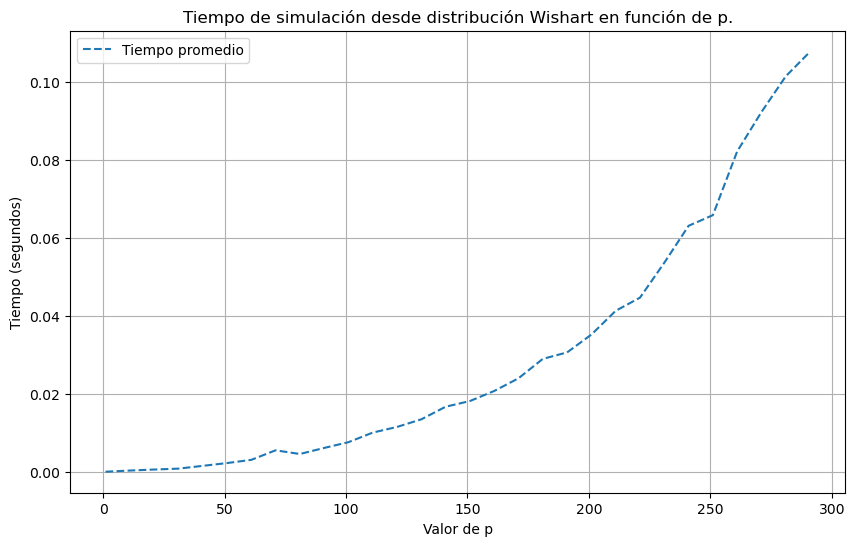

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(p_list, elapsed_times, '--', label=f'Tiempo promedio')


plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title(r'Tiempo de simulación desde distribución Wishart en función de p.')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

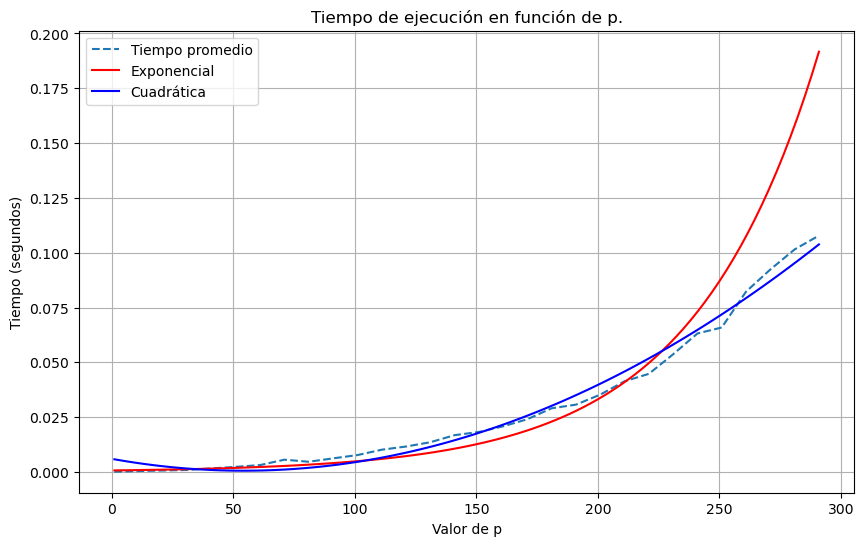

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(p_list, elapsed_times, '--', label=f'Tiempo promedio')

# Ajustar una función exponencial para k=0
k_fit = 0
times_fit = elapsed_times
params_exp, covariance_exp = np.polyfit(p_list, np.log(times_fit), 1, cov=True)
A_exp = np.exp(params_exp[1])
B_exp = params_exp[0]
fit_label_exp = f'Exponencial'

# Ajustar una función cuadrática para k=0
params_quad = np.polyfit(p_list, times_fit, 2)
A_quad = params_quad[0]
B_quad = params_quad[1]
C_quad = params_quad[2]
fit_label_quad = f'Cuadrática'

# Calcular las funciones ajustadas
p_values = np.linspace(min(p_list), max(p_list), 100)
times_exponential = A_exp * np.exp(B_exp * p_values)
times_quadratic = A_quad * p_values**2 + B_quad * p_values + C_quad

# Dibujar las funciones ajustadas
plt.plot(p_values, times_exponential, 'r-', label=fit_label_exp)
plt.plot(p_values, times_quadratic, 'b-', label=fit_label_quad)

plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title(r'Tiempo de ejecución en función de p.')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

$p$ fijo variando el $k$.

In [ ]:
p = 10

# Crear una lista de valores de k
k_list = np.arange(p, 301, 10)


# Número de iteraciones para obtener promedio
n_itr = 100

elapsed_times = []  # Lista para almacenar los tiempos de ejecución

# Iterar a través de los valores de p en p_list
for k in k_list:

    # Iniciar el contador de tiempo
    start_time = time.time()

    # Realizar n_itr simulaciones de Wishart para el valor actual de p
    Sigma = generate_covariance_matrix(p)
    M = find_M(p, k, Sigma)
    for _ in range(n_itr): 
        simulate_wishart_distribution(p, k, Sigma, M)

    # Detener el contador de tiempo y calcular el tiempo transcurrido
    end_time = time.time()
    elapsed_time = end_time - start_time

    elapsed_times.append(elapsed_time/n_itr)  # Agregar el tiempo transcurrido a la lista

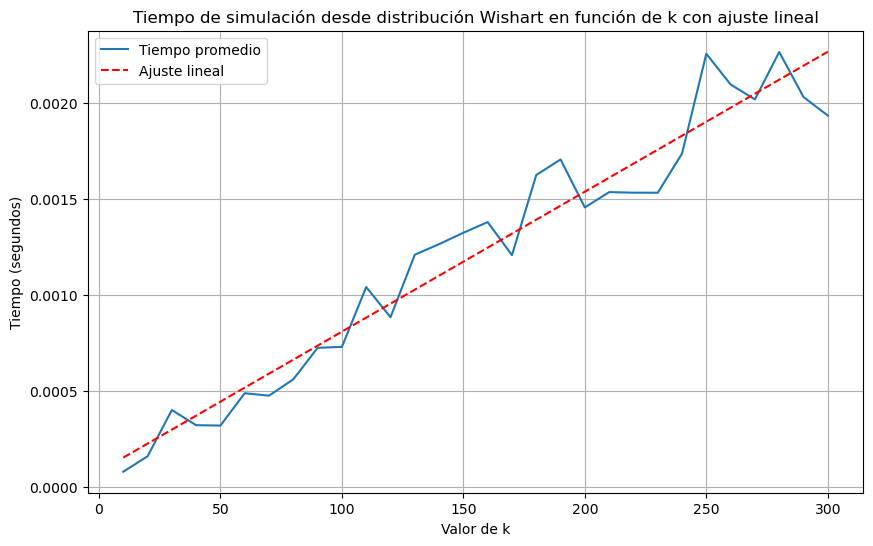

In [125]:
# Ajuste lineal
coefficients = np.polyfit(k_list, elapsed_times, 1)  # 1 indica un ajuste lineal (recta)

# Crear una función de regresión lineal basada en los coeficientes
regression_line = np.poly1d(coefficients)

# Valores x para el gráfico
x_values = np.linspace(min(k_list), max(k_list), 100)

# Calcular los valores y correspondientes a la regresión lineal
y_values = regression_line(x_values)

# Crear el gráfico
plt.figure(figsize=(10, 6))

plt.plot(k_list, elapsed_times, '-', label=f'Tiempo promedio')
plt.plot(x_values, y_values, '--', label=f'Ajuste lineal', color='red')

plt.xlabel('Valor de k')
plt.ylabel('Tiempo (segundos)')
plt.title(r'Tiempo de simulación desde distribución Wishart en función de k con ajuste lineal')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


de donde queda mucho más claro que el tiempo crece de forma cuádratica.

## 3) Comprobación de que el método funciona.

> Hay que utilizar la **Obs 3:** y verificar que: $E[X]=k\Sigma$, que para $X_{ij}$ y $\sigma_{ij}$ las entradas $(i,j)$ de las matrices $X$ y $\Sigma$ respectivamente, se tiene que $Var(X_{ij})=k(\sigma_{ij}^2+\sigma_{ii}\sigma_{jj})$. Por \'ultimo bastaria verificar que $X_{ii}\sim \sigma_{ii}\chi_{k}^2$

### Verificación del promedio.

Considere el estimador insesgado de $E[X]=k\Sigma$ como
$$
T(\underline{X})=\overline{X}
$$

Luego utilizaremos la distancia de Frobenius para determinar que tan cercana es nuestra estimación del valor real, si esta es cercana a 0, tenemos razones experimentales para determinar que la simulación funciona correctamente. La distancia de Frobenius se determina en base a su norma:
$$
||A||_F:=\left(tr(A^TA)\right)^{1/2}
$$

In [93]:
# Crear una lista de valores de p
p_list = np.arange(5, 15, 3)  # Puedes ajustar esta lista según los valores de p deseados

n_itr = 1_000

# Lista de valores de k
p = np.max(p_list)
k_list = np.arange(p, 201, 10)

# Diccionario para almacenar las distancias de Frobenius para diferentes valores de p
frobenius_distances = {p_val: [] for p_val in p_list}

# Iterar a través de los valores de p en la lista
for p in p_list:
    Sigma = generate_covariance_matrix(p)  # Generar matriz de covarianza para el valor de p actual

    for k in k_list:
        T = np.zeros((p, p))

        # Realizar n_itr simulaciones y promediar
        for _ in range(n_itr):
            T += simulate_wishart_distribution(p, k, Sigma)  # Asegúrate de tener esta función definida

        # Calcular la distancia de Frobenius entre k * Sigma y el promedio
        frobenius_distances[p].append(np.linalg.norm(k * Sigma - T / (n_itr)))

# Ahora tienes un diccionario de distancias de Frobenius para cada valor de p en p_list
# Puedes utilizar estos datos para análisis o visualización

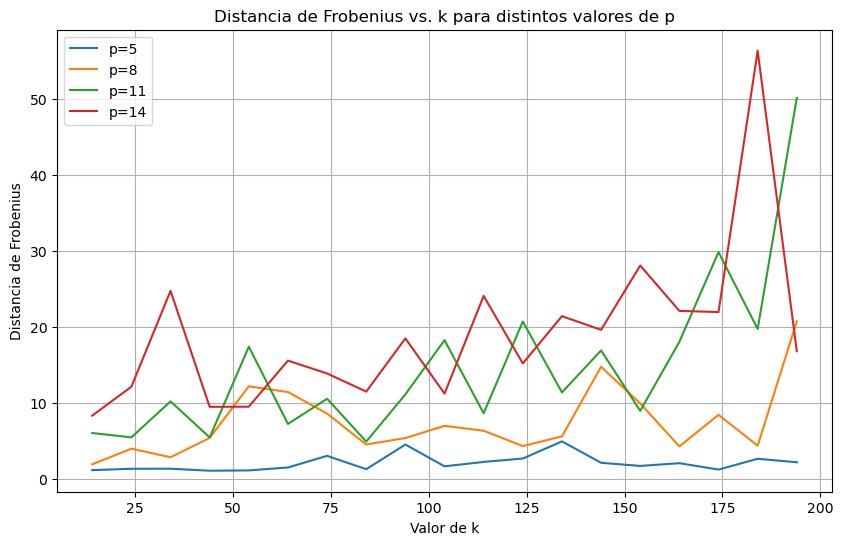

In [94]:
# Crear el gráfico de distancia de Frobenius vs. k para distintos valores de p
plt.figure(figsize=(10, 6))

for p_val in p_list:
    distances = frobenius_distances[p_val]
    plt.plot(k_list, distances, label=f'p={p_val}')

plt.xlabel('Valor de k')
plt.ylabel('Distancia de Frobenius')
plt.title('Distancia de Frobenius vs. k para distintos valores de p')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

Utilizando $1000$ muestras desde la distribución, se puede mostrar que para dimensiones bajas (menores a 5), esto es suficiente para alcanzar una precisión deseada, pero para dimensiones mayores esto no es claro. Por otro lado se muestra que para distintos $k$, aparentemente, no esto afecta al rendimiento del cálculo pero si a la varianza de la cantidad necesaria.

Para verificar que efectivamente el estimador converge a la esperanza, realizaremos pruebas de simulación y estudiaremos el número de muestras necesarias para alcanzar una precisión deseada.

In [95]:
def calculate_iterations_to_tolerance(n_max=100_000, p=1, k=None, tol=0.1, max_iterations_without_decrease=None):
    if max_iterations_without_decrease==None:
        max_iterations_without_decrease = n_max/10

    if k==None:
        k = p

    # Valores fijos de p y k
    Sigma = generate_covariance_matrix(p)

    # Inicializar contador de iteraciones
    iterations = 0

    # Inicializar una matriz T para acumular resultados
    T = np.zeros((p, p))

    # Lista para almacenar las distancias calculadas en cada ciclo
    distances = []

    # Inicializar contador de iteraciones sin disminución
    iterations_without_decrease = 0

    # Distancia más baja registrada
    lowest_distance = np.inf

    # Bucle while para iterar hasta que la distancia sea menor que tol o se alcance el máximo de iteraciones
    while iterations < n_max:
        # Realizar una simulación de Wishart
        realization = simulate_wishart_distribution(p, k, Sigma)

        # Acumular el resultado en T
        T += realization

        # Calcular la distancia de Frobenius entre T y k * Sigma
        distance = np.linalg.norm(T / (iterations + 1) - k * Sigma)

        # Agregar la distancia calculada a la lista
        distances.append(distance)

        # Verificar si la distancia es menor que la tolerancia
        if distance < tol:
            break

        # Verificar si la distancia no ha disminuido
        if distance >= lowest_distance:
            iterations_without_decrease += 1
        else:
            iterations_without_decrease = 0

        # Si no hay disminución durante un número de iteraciones especificado, terminar
        if iterations_without_decrease >= max_iterations_without_decrease:
            break

        # Actualizar la distancia más baja registrada
        lowest_distance = min(lowest_distance, distance)

        # Incrementar el contador de iteraciones
        iterations += 1

    return iterations, distances, lowest_distance

# Parámetros
p = 5
k = 10
tol = 0.1

# Llamada a la función
iterations, distances, lowest_distance = calculate_iterations_to_tolerance(p=p, k=k, tol=tol)

# Imprimir el resultado
print(f"Con {iterations} iteraciones se logró alcanzar una distancia de {distances[-1]}")


Con 22437 iteraciones se logró alcanzar una distancia de 0.09891777209327138


In [96]:
# Array de valores de p que van desde 10 hasta 100 en incrementos de 10
p_array = np.arange(1, 10 + 1, 1)

# Número máximo de iteraciones para todas las simulaciones
n_max = 1e9

# Tolerancia
tol = 1

# Listas para almacenar resultados
iterations_array = []  # Almacenará el número de iteraciones para cada valor de p
problem_array = []  # Almacenará información sobre valores de p problemáticos

# Iterar a través de los valores de p en p_array
for p in p_array:
    # Llama a la función calculate_iterations_to_tolerance
    iterations, distances, lowest_distance = calculate_iterations_to_tolerance(n_max=n_max, p=p, tol=tol)
    print(f'Listo {p=} con iteraciones {iterations=} y distance {distances[-1]}')
    
    # Si no se alcanza la tolerancia en el número máximo de iteraciones, se considera un problema
    if distances[-1]>tol:
        iterations_array.append(0)  # Agrega 0 a la lista de iteraciones (problema)
        problem_array.append([p, distances[-1]])  # Almacena información sobre el problema
    else:
        iterations_array.append(iterations)  # Agrega el número de iteraciones a la lista

# Al finalizar el bucle, tendrás dos listas:
# iterations_array con el número de iteraciones para cada valor de p (o 0 si hubo un problema).
# problem_array con información sobre los valores de p problemáticos que no alcanzaron la tolerancia en el número máximo de iteraciones.

Listo p=1 con iteraciones iterations=0 y distance 0.24386574494034374
Listo p=2 con iteraciones iterations=0 y distance 0.6667067281906118
Listo p=3 con iteraciones iterations=5 y distance 0.8742781414861199
Listo p=4 con iteraciones iterations=32 y distance 0.918439535390164
Listo p=5 con iteraciones iterations=55 y distance 0.8178534129353905
Listo p=6 con iteraciones iterations=81 y distance 0.8899858092193542
Listo p=7 con iteraciones iterations=1285 y distance 0.9898055634064881
Listo p=8 con iteraciones iterations=1827 y distance 0.9224546052130883
Listo p=9 con iteraciones iterations=2464 y distance 0.994234099666295
Listo p=10 con iteraciones iterations=3294 y distance 0.9722503228167966


Ahora considere el mismo procedimiento, pero considerando el promedio de iteraciones para varias simulaciones para cada $p$ con la finalidad de obtener una curva con menos varianza.

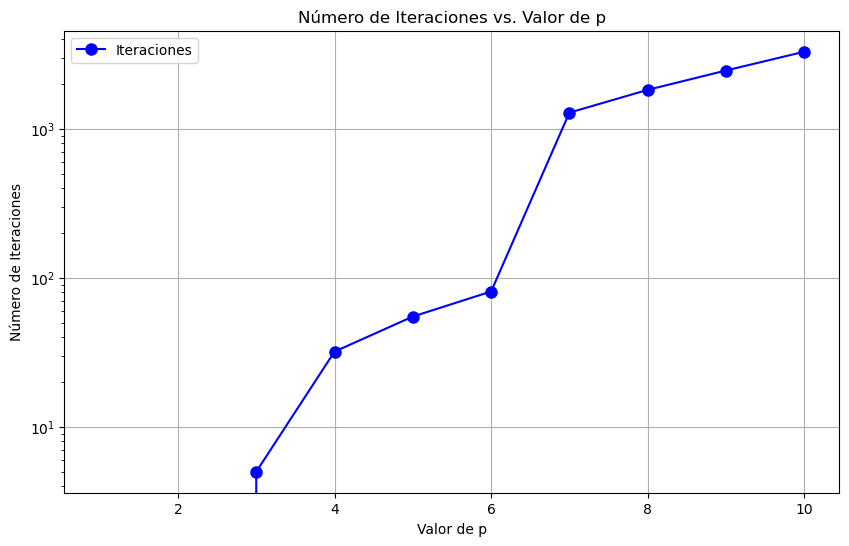

In [97]:
# Crear el gráfico
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Personalizar el estilo de línea y los marcadores
plt.plot(p_array, iterations_array, marker='o', linestyle='-', color='b', markersize=8, label='Iteraciones')

plt.yscale('log')

# Etiquetas de ejes y título
plt.xlabel('Valor de p')
plt.ylabel('Número de Iteraciones')
plt.title('Número de Iteraciones vs. Valor de p')

# Mostrar una cuadrícula
plt.grid(True)

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


El número de iteraciones necesarias para llegar a la convergencia crece de manera muy rápida en función del $p$.

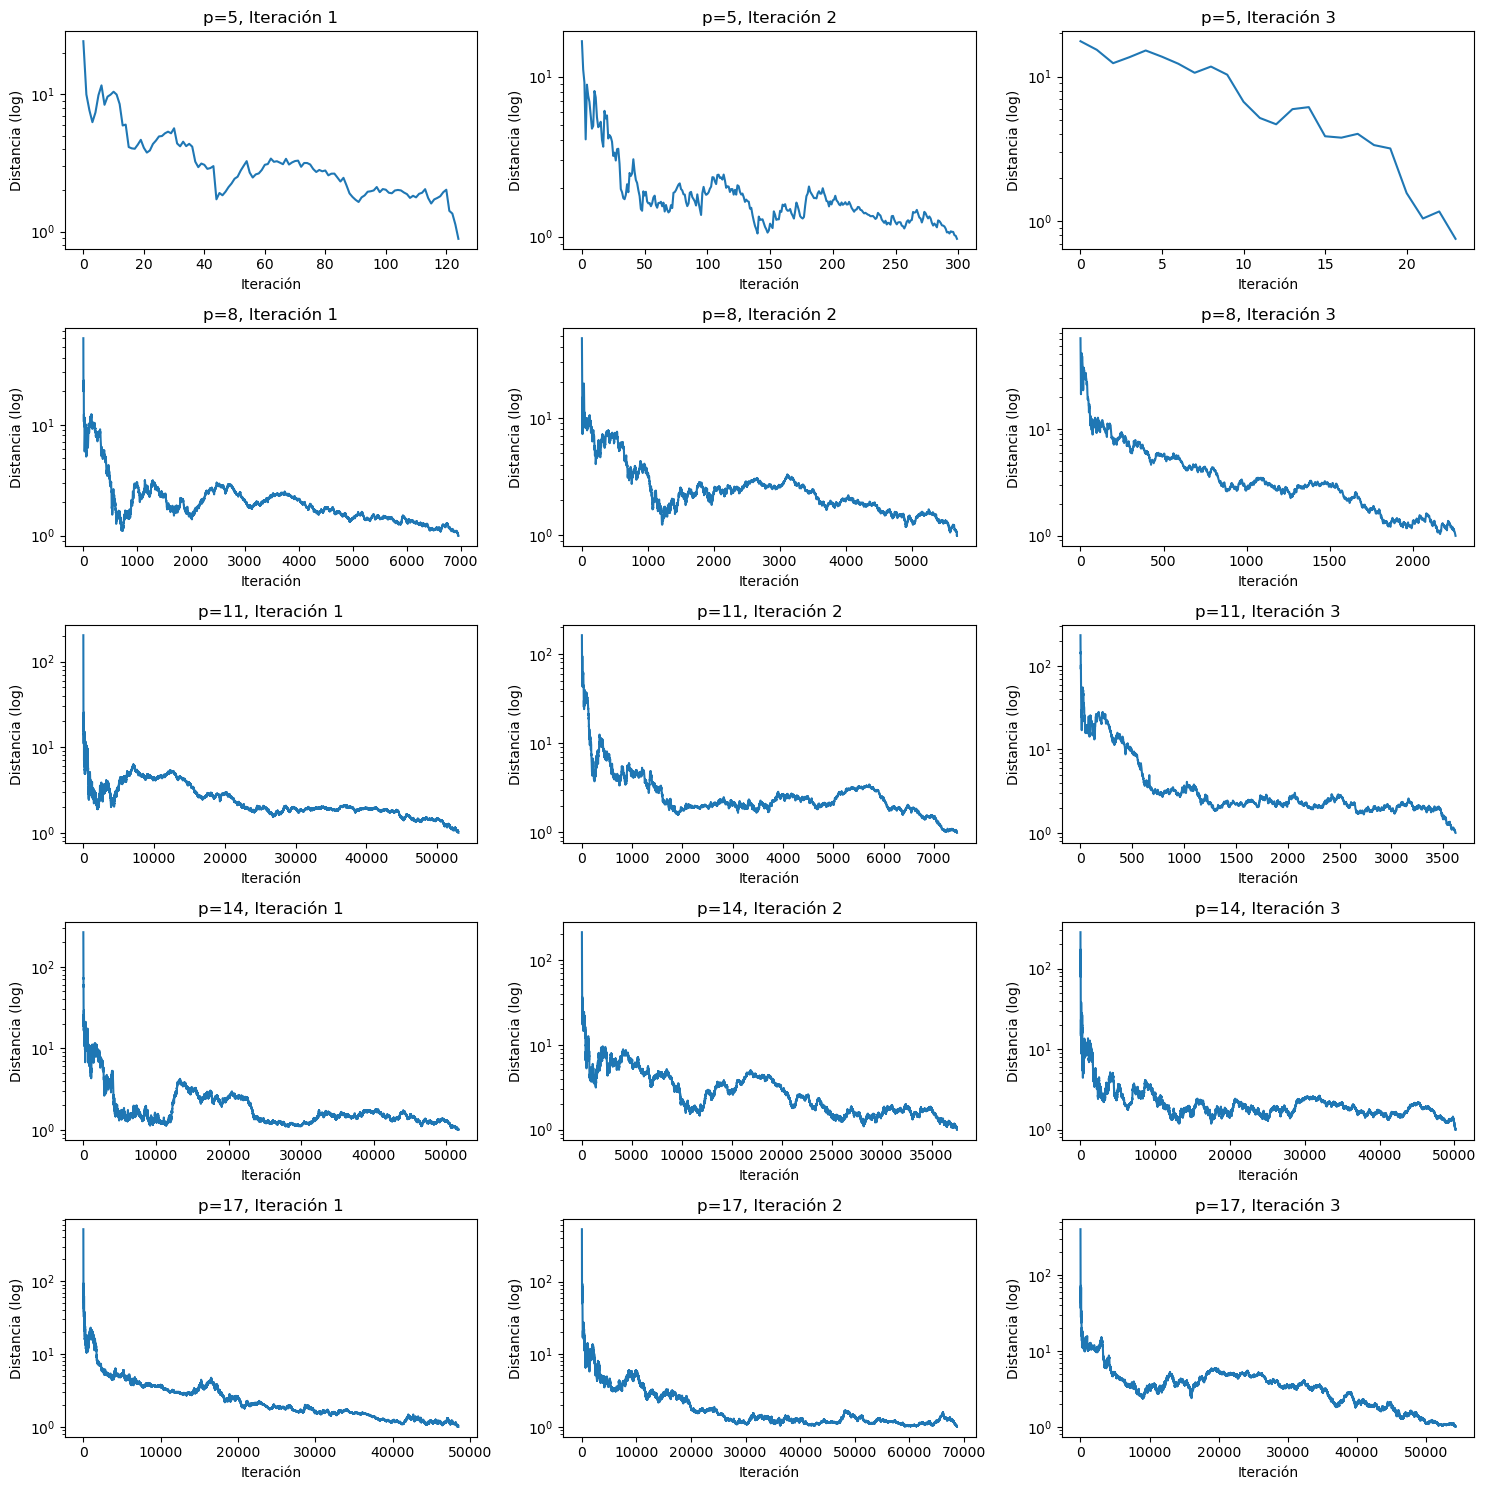

In [99]:
#iterations, distances, lowest_distance = calculate_iterations_to_tolerance(p=p, k=k, tol=tol)
p_list = [5,8,11,14,17]

distances_dic = {}

for p in p_list:
    distances_dic[p] = []

    for _ in range(3):
        iterations, distances, lowest_distance = calculate_iterations_to_tolerance(n_max=1_000_000, p=p, tol=1)
        distances_dic[p].append(distances)
        
# Crear una grilla 5x3 para graficar
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

# Iterar a través de las filas y columnas de la grilla
for i, p in enumerate(p_list):
    for j in range(3):
        distances = distances_dic[p][j]  # Obtener las distancias correspondientes a p y la iteración j
        
        # Graficar las distancias en escala logarítmica
        axs[i, j].semilogy(np.arange(len(distances)), distances)
        axs[i, j].set_title(f'p={p}, Iteración {j+1}')
        axs[i, j].set_xlabel('Iteración')
        axs[i, j].set_ylabel('Distancia (log)')

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Realmente hay un problema al momento de querer aproximarse al promedio y se puede conjeturar que la cantidad de iteraciones necesarias tiene una varianza alta.

In [100]:
n = 100

p = 5

iterations_array = []

for _ in range(n):
    iterations, distances, lowest_distance = calculate_iterations_to_tolerance(n_max=1_000_000, p=p, tol=1)
    iterations_array.append(iterations)

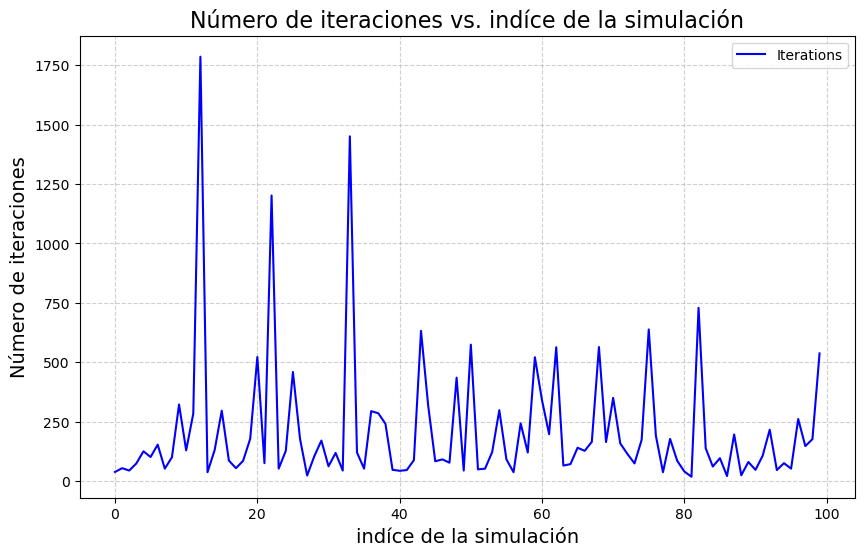

In [101]:
# Crear el gráfico
plt.figure(figsize=(10, 6))  # Establecer el tamaño de la figura

# Plotear los datos
plt.plot(np.arange(n), iterations_array, label='Iterations', color='blue')

# Agregar etiquetas de ejes
plt.xlabel('indíce de la simulación', fontsize=14)
plt.ylabel('Número de iteraciones', fontsize=14)

# Agregar título
plt.title('Número de iteraciones vs. indíce de la simulación', fontsize=16)

# Agregar una cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Agregar una leyenda
plt.legend(loc='upper right')

# Mostrar el gráfico
plt.show()

In [102]:
print(f'Número de iteraciones: {n}')
print(f'Promedio de iteraciones: {np.mean(iterations)}')
print(f'Desviación estandar: {np.sqrt(np.var(iterations_array))}')

Número de iteraciones: 100
Promedio de iteraciones: 537.0
Desviación estandar: 277.5926459760777


### Verificación de la varianza de la matriz.

Se calcula la varianza muestral mediante calcular la varianza mirando unicamente dicha componente de las matriz y se compara con la varianza teorica para ver si realmente hacen sentido.

In [103]:
def calcular_varianzas(matrices):
    # Convertir el array de matrices en un único array tridimensional
    matrices_concatenadas = np.stack(matrices)
    
    # Calcular la varianza en cada posición usando axis=0
    varianzas = np.var(matrices_concatenadas, axis=0)
    
    return varianzas

# Ejemplo de uso:
matrices = [np.array([[1, 1], [1, 1]]), np.array([[1, 2], [3, 4]]), np.array([[1, 3], [5, 7]])]
resultados = calcular_varianzas(matrices)

# Imprimir las varianzas
print(resultados)

[[0.         0.66666667]
 [2.66666667 6.        ]]


In [104]:
import numpy as np

def calculate_varianza_teorica(k, Sigma):
    """
    Calcula una matriz donde cada entrada es de la forma k(\sigma_{ij}^2 + \sigma_{ii}\sigma_{jj}).

    Parámetros:
    k (float): El valor k.
    matriz_sigma (numpy.ndarray): La matriz sigma de entrada.

    Retorna:
    numpy.ndarray: La matriz calculada según la fórmula.
    """
    # Obtener las dimensiones de la matriz sigma
    n, m = Sigma.shape
    
    # Crear una matriz vacía con las mismas dimensiones
    matriz_resultado = np.empty_like(Sigma)
    
    # Calcular cada entrada de la matriz resultado
    for i in range(n):
        for j in range(m):
            matriz_resultado[i, j] = k * (Sigma[i, j]**2 + Sigma[i, i] * Sigma[j, j])
    
    return matriz_resultado

# Ejemplo de uso:
k = 2.0  # Valor de k
matriz_sigma = np.array([[1.0, 0.5], [0.5, 2.0]])  # Matriz sigma de ejemplo

matriz_varianza_teorica = calculate_varianza_teorica(k, matriz_sigma)

# Imprimir la matriz de varianza teórica
print(matriz_varianza_teorica)

[[ 4.   4.5]
 [ 4.5 16. ]]


In [105]:
# Definir los parámetros
p = 3  # Dimensión de la matriz
k = 5  # Parámetro k
Sigma = generate_covariance_matrix(p)

# Número de realizaciones
n_realizaciones = 10000

# Generar un array de 100 realizaciones
realizaciones = [simulate_wishart_distribution(p, k, Sigma) for _ in range(n_realizaciones)]

varianza_calculada = calcular_varianzas(realizaciones)

varianza_teorica = calculate_varianza_teorica(k, Sigma)


# Mostremos ambas
print("Varianza teorica:")
print(varianza_teorica)

print("Varianza calculada:")
print(varianza_calculada)

print("Distancia entre ambas:")
print(np.linalg.norm(varianza_calculada - varianza_teorica))

Varianza teorica:
[[22.45993074  9.68152376 11.523424  ]
 [ 9.68152376 10.31887991 10.11199293]
 [11.523424   10.11199293 11.02726361]]
Varianza calculada:
[[23.23230456  9.86361943 11.72635206]
 [ 9.86361943 10.76614238 10.50527502]
 [11.72635206 10.50527502 11.35333041]]
Distancia entre ambas:
1.1665948108673587


In [130]:
# Definir los parámetros
p = 4  # Dimensión de la matriz
k = 5  # Parámetro k
Sigma = generate_covariance_matrix(p)

# Número de realizaciones
n_realizaciones = 10000

# Generar un array de 100 realizaciones
realizaciones = [simulate_wishart_distribution(p, k, Sigma) for _ in range(n_realizaciones)]

varianza_calculada = calcular_varianzas(realizaciones)

varianza_teorica = calculate_varianza_teorica(k, Sigma)

# Imprimir en formato LaTeX
print(r'\textbf{Varianza teórica:}')
print(r'$$')
print(r'\begin{bmatrix}')
for row in varianza_teorica:
    row_str = ' & '.join([f'{val:.2f}' for val in row])
    print(row_str + r' \\')
print(r'\end{bmatrix}')
print(r'$$')

print(r'\textbf{Varianza calculada:}')
print(r'$$')
print(r'\begin{bmatrix}')
for row in varianza_calculada:
    row_str = ' & '.join([f'{val:.2f}' for val in row])
    print(row_str + r' \\')
print(r'\end{bmatrix}')
print(r'$$')

print(r'\textbf{Distancia entre ambas:}')
print(r'$' + str(np.linalg.norm(varianza_calculada - varianza_teorica)) + r'$')


\textbf{Varianza teórica:}
$$
\begin{bmatrix}
6.65 & 8.49 & 2.00 & 13.70 \\
8.49 & 11.68 & 2.63 & 17.86 \\
2.00 & 2.63 & 0.64 & 4.28 \\
13.70 & 17.86 & 4.28 & 28.99 \\
\end{bmatrix}
$$
\textbf{Varianza calculada:}
$$
\begin{bmatrix}
6.32 & 8.09 & 1.90 & 13.02 \\
8.09 & 11.23 & 2.51 & 17.02 \\
1.90 & 2.51 & 0.61 & 4.06 \\
13.02 & 17.02 & 4.06 & 27.51 \\
\end{bmatrix}
$$
\textbf{Distancia entre ambas:}
$2.308126783446759$


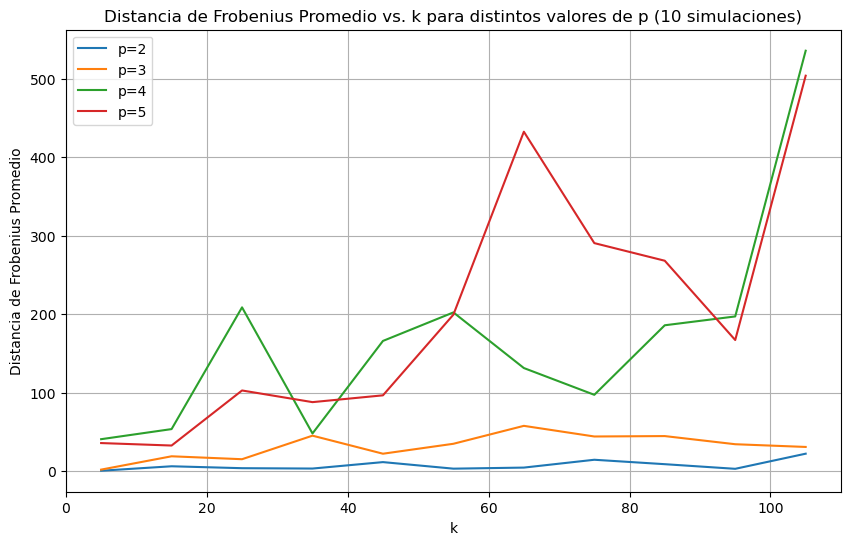

In [106]:
# Lista de valores de p
p_list = np.arange(2, 6)

# Lista de valores de k
k_list = np.arange(np.max(p_list), 101 + 10, 10)

# Diccionario para almacenar las distancias de Frobenius promedio
frobenius_distances = {p_val: [] for p_val in p_list}

# Realizar cálculos para diferentes valores de p y k
n_simulations = 100  # Número de simulaciones a utilizar

for p in p_list:
    Sigma = generate_covariance_matrix(p)  # Utiliza la función existente

    for k in k_list:
        varianza_teo = calculate_varianza_teorica(k, Sigma)

        # Simula múltiples 
        realizaciones = [simulate_wishart_distribution(p, k, Sigma) for _ in range(n_simulations)]

        varianza_cal = calcular_varianzas(realizaciones)

        frobenius_distances[p].append(np.linalg.norm(varianza_teo - varianza_cal))

# Grafica las distancias de Frobenius promedio vs. k para distintos valores de p
plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(k_list, frobenius_distances[p], label=f'p={p}')

plt.xlabel('k')
plt.ylabel('Distancia de Frobenius Promedio')
plt.title('Distancia de Frobenius Promedio vs. k para distintos valores de p (10 simulaciones)')
plt.legend()
plt.grid(True)
plt.show()

El calculo de la varianza parece tener sentido pero parece que aumenta a medida que cambia el $k$.

In [107]:
# Lista de valores de p
p_list = np.arange(3, 12, 1)

# Tolerancia para la distancia de Frobenius
tol = 2

# Diccionario para almacenar las iteraciones necesarias
iterations_needed = {p_val: 0 for p_val in p_list}
frobenius_distances = {p_val: [] for p_val in p_list}

# Número máximo de simulaciones
n_max = 3*1e3 

for p in p_list:

    # Genera la matriz de covarianza Sigma para el valor de p actual
    Sigma = generate_covariance_matrix(p)
    
    # Calcula la matriz de varianza teórica
    varianza_teo = calculate_varianza_teorica(p, Sigma)
    
    # Inicializa una lista de realizaciones con una simulación
    realizaciones = [simulate_wishart_distribution(p, p, Sigma)]
    
    # Calcula la varianza de las realizaciones actuales
    varianza_cal = calcular_varianzas(realizaciones)

    # Realiza simulaciones adicionales hasta alcanzar el número máximo o cumplir la tolerancia
    while len(realizaciones) < n_max:
        # Realiza una simulación adicional
        realizaciones.append(simulate_wishart_distribution(p, p, Sigma))

        # Calcula la varianza de las realizaciones actualizadas
        varianza_cal = calcular_varianzas(realizaciones)

        # Calcula la distancia de Frobenius actualizada
        frobenius_distance = np.linalg.norm(varianza_teo - varianza_cal)
        frobenius_distances[p].append(frobenius_distance)
        
        # Verifica si la distancia de Frobenius es menor que la tolerancia
        if frobenius_distance < tol:
            iterations_needed[p] = len(realizaciones)  # Almacena el número de iteraciones
            print(f"{p=} is ready with {iterations_needed[p]} iterations")
            break
    if len(realizaciones) == n_max: iterations_needed[p] = n_max; print(f"{p=} alcanzó el límite de iteraciones con una distancia de {frobenius_distance}.")

p=3 is ready with 70 iterations
p=4 is ready with 723 iterations
p=5 is ready with 1138 iterations
p=6 alcanzó el límite de iteraciones con una distancia de 16.409992733803684.
p=7 alcanzó el límite de iteraciones con una distancia de 23.391774708874557.
p=8 alcanzó el límite de iteraciones con una distancia de 20.58098535111997.
p=9 alcanzó el límite de iteraciones con una distancia de 10.741047192214634.
p=10 alcanzó el límite de iteraciones con una distancia de 49.9896141092537.
p=11 alcanzó el límite de iteraciones con una distancia de 31.467997237087925.


In [108]:
print(iterations_needed)

{3: 70, 4: 723, 5: 1138, 6: 3000.0, 7: 3000.0, 8: 3000.0, 9: 3000.0, 10: 3000.0, 11: 3000.0}


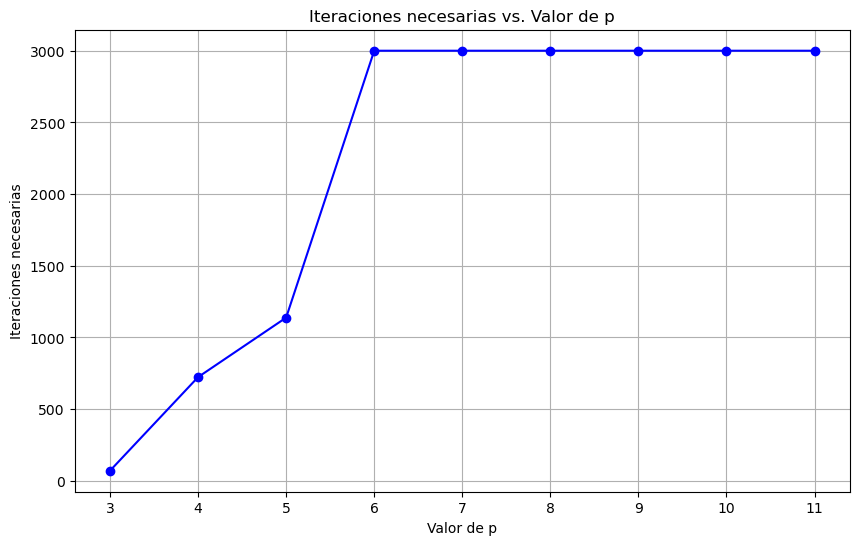

In [109]:
# Obtener las claves (p_list) y valores (iteraciones necesarias) del diccionario
p_list = list(iterations_needed.keys())
iterations = list(iterations_needed.values())

# Graficar los valores vs. las claves
plt.figure(figsize=(10, 6))
plt.plot(p_list, iterations, marker='o', linestyle='-', color='b')
plt.xlabel('Valor de p')
plt.ylabel('Iteraciones necesarias')
plt.title('Iteraciones necesarias vs. Valor de p')
plt.grid(True)
plt.show()

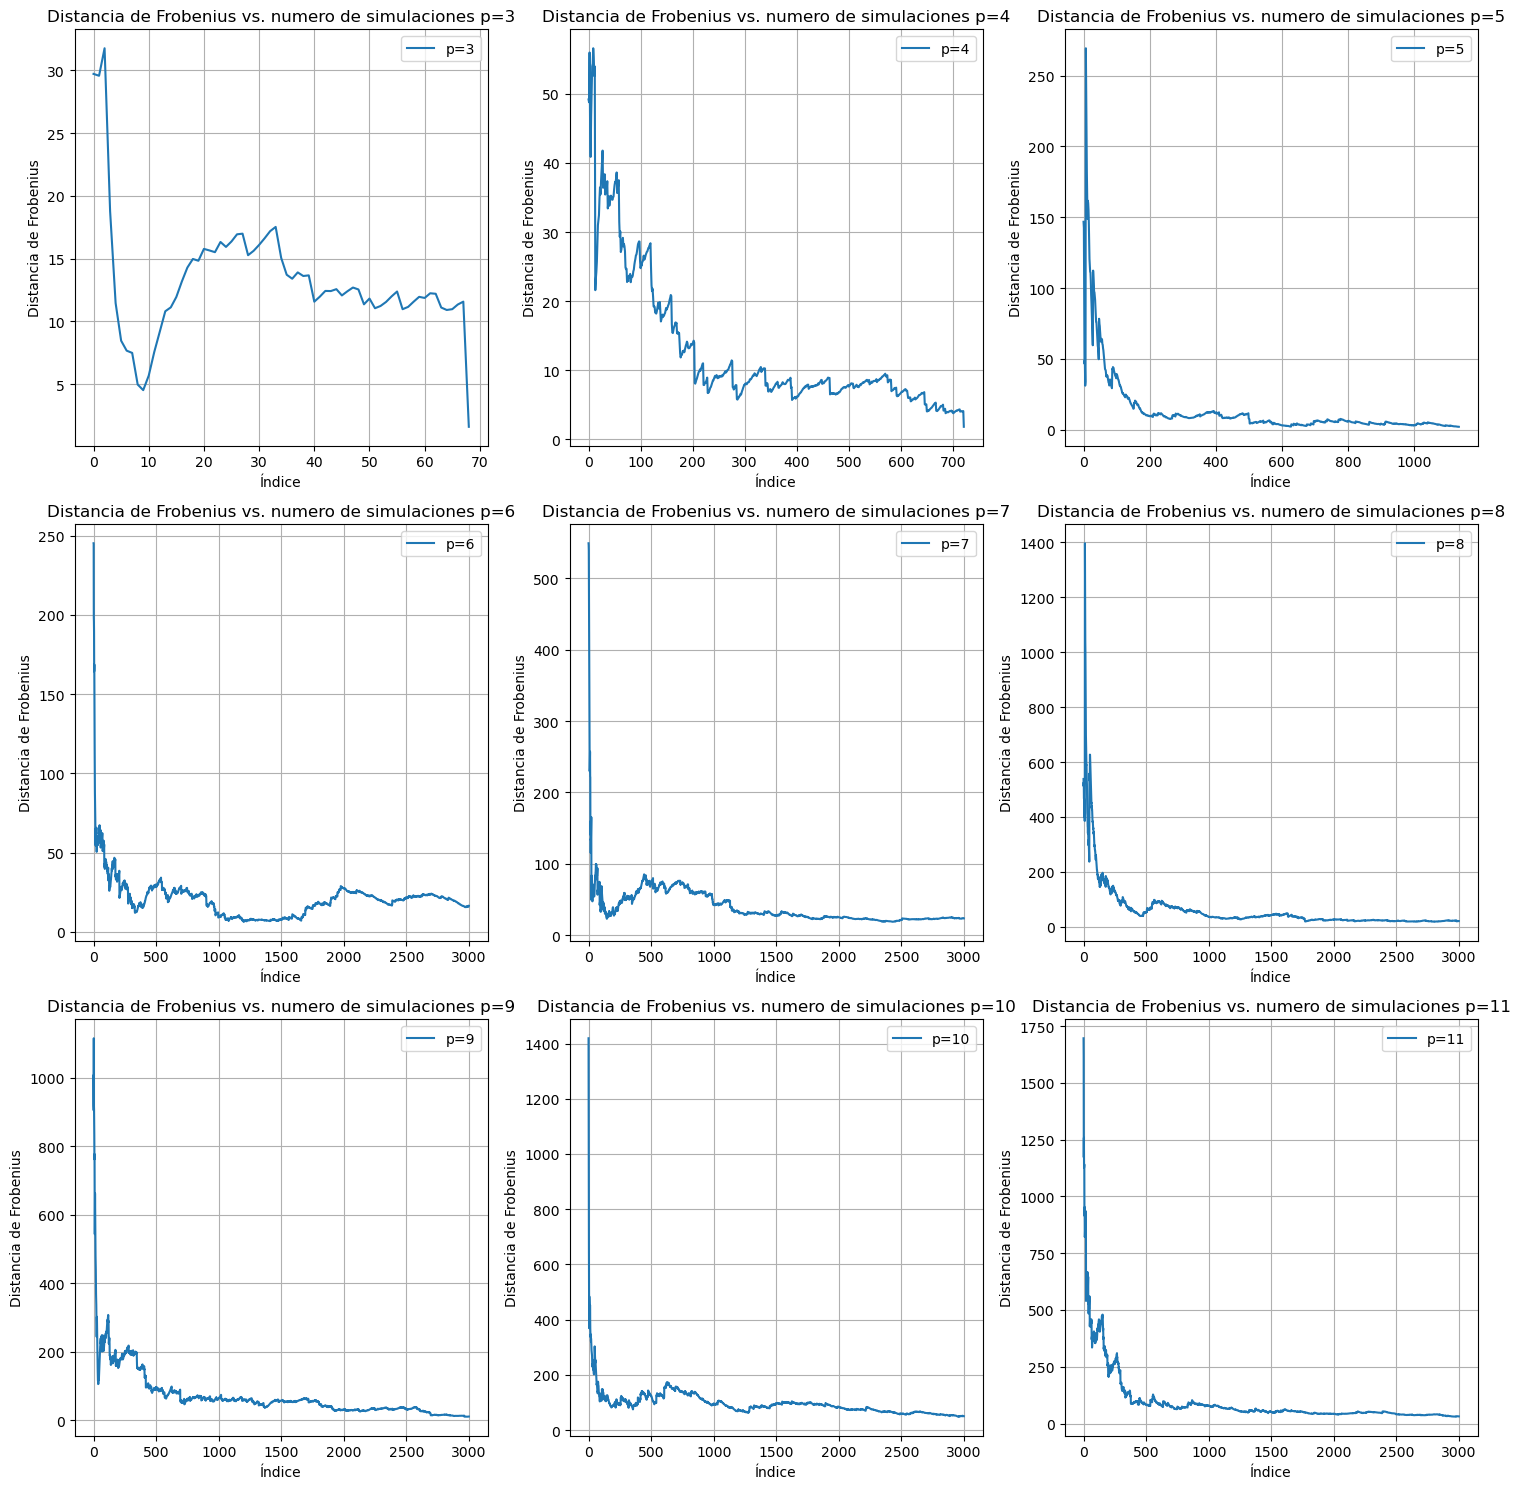

In [110]:
# Determine la disposición de filas y columnas en función de la longitud de p_list
num_plots = len(p_list)
num_cols = 3
num_rows = int(np.ceil(num_plots / num_cols))

# Tamaño de la figura
fig_width = 15  # Ancho de la figura en pulgadas
fig_height = num_rows * 5  # Altura de la figura en pulgadas (ajustable según tus necesidades)

# Crea una figura con una cuadrícula de subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Itera a través de los valores de p en p_list
for i, p in enumerate(p_list):
    # Obtén las distancias de Frobenius para el valor de p actual
    distances = frobenius_distances[p]

    # Determine las coordenadas (fila, columna) en la cuadrícula
    row = i // num_cols
    col = i % num_cols

    # Plotea en el subgráfico correspondiente
    ax = axes[row, col]
    ax.plot(range(len(distances)), distances, label=f'p={p}')
    ax.set_xlabel('Índice')
    ax.set_ylabel('Distancia de Frobenius')
    ax.set_title(f'Distancia de Frobenius vs. numero de simulaciones p={p}')
    ax.legend()
    ax.grid(True)

# Ajusta el espacio entre los gráficos y muestra la figura
plt.tight_layout()
plt.show()

## 4) El hardware utilizado.

Procesador	11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz   2.80 GHz

RAM instalada	16,0 GB (15,7 GB usable)

Tipo de sistema	Sistema operativo de 64 bits, procesador basado en x64


## 5) Información que puede ser relevante.

Se puede encontrar información oficial de https://www.stat.pitt.edu/sungkyu/course/2221Fall13/lec2.pdf de la universidad de pittsburgh.

También se puede corroborar y entender desde las clases del profesor Felipe Osorio publicadas en su Github: https://github.com/faosorios/Curso-Multivariado/blob/main/diapositivas/2022/MAT269_slides-06.pdf

## 6) Simulando para $\lambda_i\in[0,\lambda_{\max}]$

Trivial.

# Extension a k fractionario

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [2]:
def generate_covariance_matrix(p=1):
    while True:
        # Generate a random p x p matrix with values between 0 and 1
        B = np.random.rand(p, p)

        # Calculate the covariance matrix
        Sigma = B @ B.T

        # Check if the covariance matrix is positive definite
        if is_positive_definite(Sigma):
            return Sigma

def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

# Example of usage
p_dimension = 3  # Replace with the desired dimension
cov_matrix = generate_covariance_matrix(p_dimension)

print("Covariance Matrix Sigma:")
print(cov_matrix)

print("Es definida positiva:")
print(is_positive_definite(cov_matrix))

Covariance Matrix Sigma:
[[0.18092133 0.44852835 0.43236315]
 [0.44852835 1.78454806 1.51995255]
 [0.43236315 1.51995255 1.49162697]]
Es definida positiva:
True


In [4]:
def simulate_wishart_distribution_int(p, k=None, Sigma=None):
    # Verifica si no se proporcionó una matriz B, en cuyo caso se utiliza la matriz identidad por defecto
    if Sigma is None:
        Sigma = np.identity(p)

    # Verifica si no se proporcionó el número de grados de libertad k, en cuyo caso se utiliza k = p por defecto
    if k is None:
        k = p

    # Calcula la factorización Cholesky
    B = np.linalg.cholesky(Sigma)

    # Inicializa una matriz X de ceros de tamaño (p, p) para acumular los productos
    X = np.zeros((p, p))

    # Itera k veces para simular los grados de libertad de la distribución Wishart
    for _ in range(k):
        # Genera p números aleatorios de una distribución normal estándar con media 0 y desviación estándar 1
        Y = np.random.normal(0, 1, p)

        X += np.outer(Y, Y)

    # Escala la matriz resultante según la matriz de escala B
    X = B @ X @ B.T

    # Devuelve la matriz resultante que sigue una distribución Wishart
    return X


# Example of usage
p_dimension = 3  # Dimension of the random vectors
num_vectors = 5  # Number of random vectors to simulate

# Simulate random vectors with a custom covariance matrix
Sigma= generate_covariance_matrix(p_dimension)
simulated_data_custom = simulate_wishart_distribution_int(p_dimension, num_vectors, Sigma = Sigma)
print("Simulated Data from wishart distribution for k int:")
print(simulated_data_custom)

Simulated Data from wishart distribution for k int:
[[ 3.10399246  3.42297666  0.47721306]
 [ 3.42297666  3.85003183 -0.08073626]
 [ 0.47721306 -0.08073626  5.190705  ]]


In [72]:
def find_M(p, k, Sigma, n_samples=100):
    M = []
    _, kk = math.modf(k)
    kk = int(kk + 1)
    for _ in range(n_samples):
        X = simulate_wishart_distribution_int(p, kk, Sigma)
        M.append(np.linalg.det(X) ** ((k - kk) / 2))
    M = np.max(M)
    return M

def simulate_wishart_distribution(p, k=None, Sigma=None, M=None):
    if Sigma is None:
        Sigma = np.identity(p)

    # Verifica si no se proporcionó el número de grados de libertad k, en cuyo caso se utiliza k = p por defecto
    if k is None:
        k = p


    if M is None:
        M = find_M(p, k, Sigma)

    _, kk = math.modf(k)

    if kk == k:
        return simulate_wishart_distribution_int(p, int(k), Sigma), 0

    kk = int(kk + 1)

    itr_max_intern = 1_000

    itr_actual_intern = 0
    while True:
        itr_actual_intern += 1
        if itr_actual_intern == itr_max_intern: return print(f'itr_max_intern alcanced.')
        X = simulate_wishart_distribution_int(p, kk, Sigma)
        U = np.random.uniform(0,1)
        if U <= np.linalg.det(X) ** ((k - kk) / 2)/M:
            rechazados  = itr_actual_intern-1
            return X, rechazados

# Ejemplo de uso
p = 5  # Dimensión de la matriz Wishart
k = 10.62  # Grados de libertad
Sigma = generate_covariance_matrix(p)  # Matriz de covarianza

# Encuentra el valor M para la distribución instrumental g
M = find_M(p, k, Sigma)

# Simula una matriz desde la distribución Wishart
sample, rechazados = simulate_wishart_distribution(p, k, Sigma, M)

print("Muestra de la distribución Wishart:")
print(sample)

print("\nSe rechazaron para llegar a este:")
print(rechazados)

Muestra de la distribución Wishart:
[[29.90446394 31.60739668 15.02916786 14.48148829 15.13368474]
 [31.60739668 39.78699291 15.79930841 17.45347553 17.38306992]
 [15.02916786 15.79930841  9.62273432  8.69627673  9.7159015 ]
 [14.48148829 17.45347553  8.69627673  9.58501393  9.52007161]
 [15.13368474 17.38306992  9.7159015   9.52007161 10.2210486 ]]

Se rechazaron para llegar a este:
1


para evitar el efecto que pueda provenir de la elección de $\Sigma$, se realizar\'an m\'ultiples iteraciones para cada par $k,p$ que se quiera realizar, generando una nueva matriz $\Sigma$ cada vez y por ende, calculando la cota $M$. A continuación se utiliza este procedimiento para mostrar la taza de rechazo promedio en función de $k$ y $p$.

In [81]:
def calculate_iterations_to_tolerance(n_max=100_000, p=1, k=None, tol=0.1, max_iterations_without_decrease=None):
    if max_iterations_without_decrease==None:
        max_iterations_without_decrease = n_max/10

    if k==None:
        k = p

    # Valores fijos de p y k

    # Inicializar contador de iteraciones
    iterations = 0

    # Inicializar una matriz T para acumular resultados
    T = np.zeros((p, p))

    # Lista para almacenar las distancias calculadas en cada ciclo
    distances = []

    # Inicializar contador de iteraciones sin disminución
    iterations_without_decrease = 0

    # Distancia más baja registrada
    lowest_distance = np.inf

    # Guarda la cantidad de rechazados totales
    rechazados = 0

    # Bucle while para iterar hasta que la distancia sea menor que tol o se alcance el máximo de iteraciones
    while iterations < n_max:
        # Realizar una simulación de Wishart
        Sigma = generate_covariance_matrix(p)

        M = find_M(p, k, Sigma)
        
        realization, num_rechazos = simulate_wishart_distribution(p, k, Sigma, M)

        # Acumular el resultado en T
        T += realization

        # Acumular el resultado de rechazados
        rechazados += num_rechazos

        # Calcular la distancia de Frobenius entre T y k * Sigma
        distance = np.linalg.norm(T / (iterations + 1) - k * Sigma)

        # Agregar la distancia calculada a la lista
        distances.append(distance)

        # Verificar si la distancia es menor que la tolerancia
        if distance < tol:
            break

        # Verificar si la distancia no ha disminuido
        if distance >= lowest_distance:
            iterations_without_decrease += 1
        else:
            iterations_without_decrease = 0

        # Si no hay disminución durante un número de iteraciones especificado, terminar
        if iterations_without_decrease >= max_iterations_without_decrease:
            break

        # Actualizar la distancia más baja registrada
        lowest_distance = min(lowest_distance, distance)

        # Incrementar el contador de iteraciones
        iterations += 1

    return iterations, distances, lowest_distance, rechazados

# Parámetros
p = 5
k = p + 1.652
tol = 0.1

# Llamada a la función
iterations, distances, lowest_distance, rechazados = calculate_iterations_to_tolerance(p=p, k=k, tol=tol)

# Imprimir el resultado
print(f"Con {iterations} iteraciones se logró alcanzar una distancia de {distances[-1]}")

# Ratio de rechazos en este caso
print(f'Se rechazaron en total {rechazados}, por ende el ratio de rechazos por simulacion es {rechazados/iterations}')

Con 24834 iteraciones se logró alcanzar una distancia de 11.262984761449157
Se rechazaron en total 30943, por ende el ratio de rechazos por simulacion es 1.245993396150439


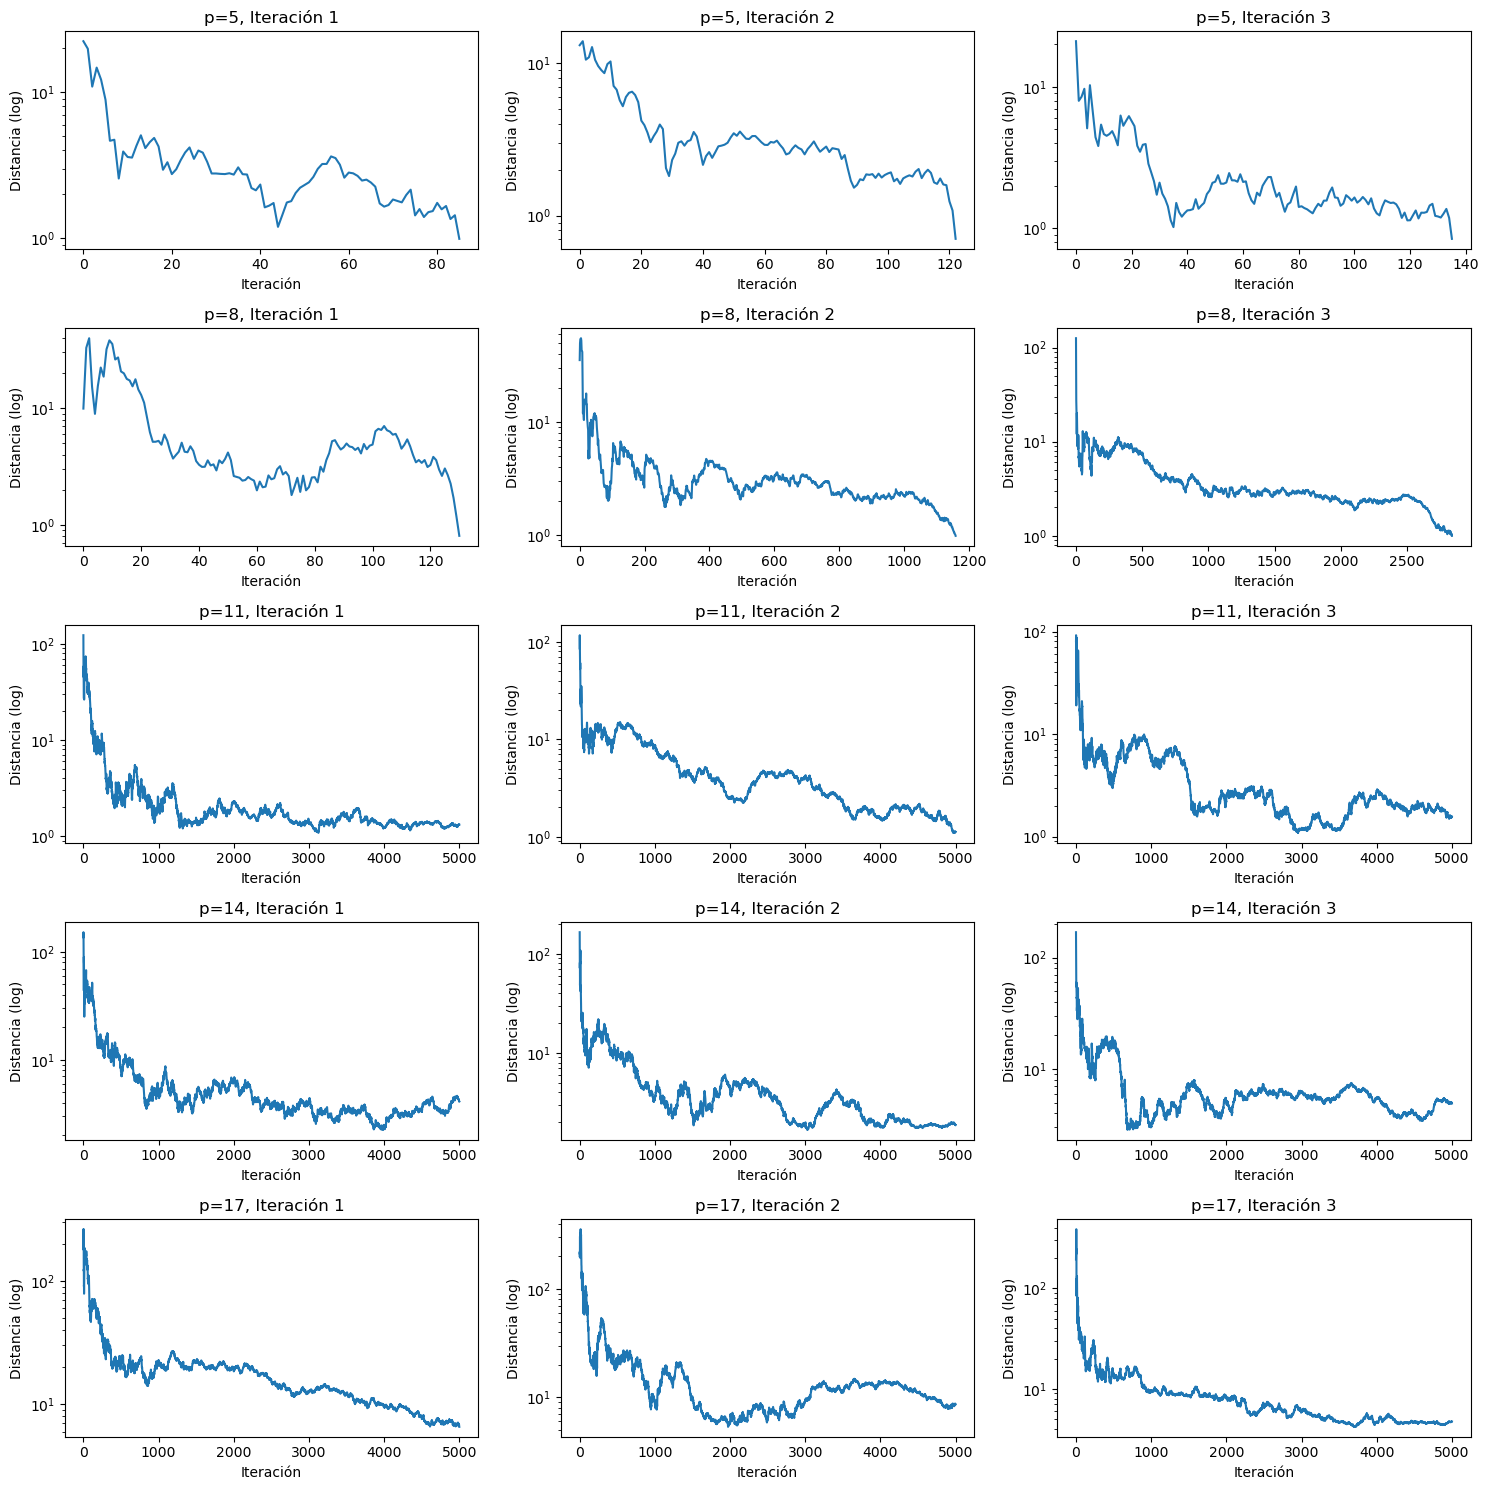

In [78]:
#iterations, distances, lowest_distance = calculate_iterations_to_tolerance(p=p, k=k, tol=tol)
p_list = [5,8,11,14,17]

distances_dic = {}

for p in p_list:
    distances_dic[p] = []

    for _ in range(3):
        iterations, distances, lowest_distance, rechazos = calculate_iterations_to_tolerance(n_max=5_000, p=p, k= p-0.523,tol=1, max_iterations_without_decrease=5_000)
        distances_dic[p].append(distances)
        
# Crear una grilla 5x3 para graficar
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

# Iterar a través de las filas y columnas de la grilla
for i, p in enumerate(p_list):
    for j in range(3):
        distances = distances_dic[p][j]  # Obtener las distancias correspondientes a p y la iteración j
        
        # Graficar las distancias en escala logarítmica
        axs[i, j].semilogy(np.arange(len(distances)), distances)
        axs[i, j].set_title(f'p={p}, Iteración {j+1}')
        axs[i, j].set_xlabel('Iteración')
        axs[i, j].set_ylabel('Distancia (log)')

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Claramente para el valor $k=p-0.523>p-1$ el método parece tener más problemas para converger. Del gráfico anterior, se debe notar que la noción de convergencia con esta norma depende de cierta manera de la dimensión que se esté trabajando, donde para las dimensiones altas, podríamos afirmar que el hecho de que la distancia con la esperanza teórica sea menos de $10$ da una noción de convergencia adecuada. 

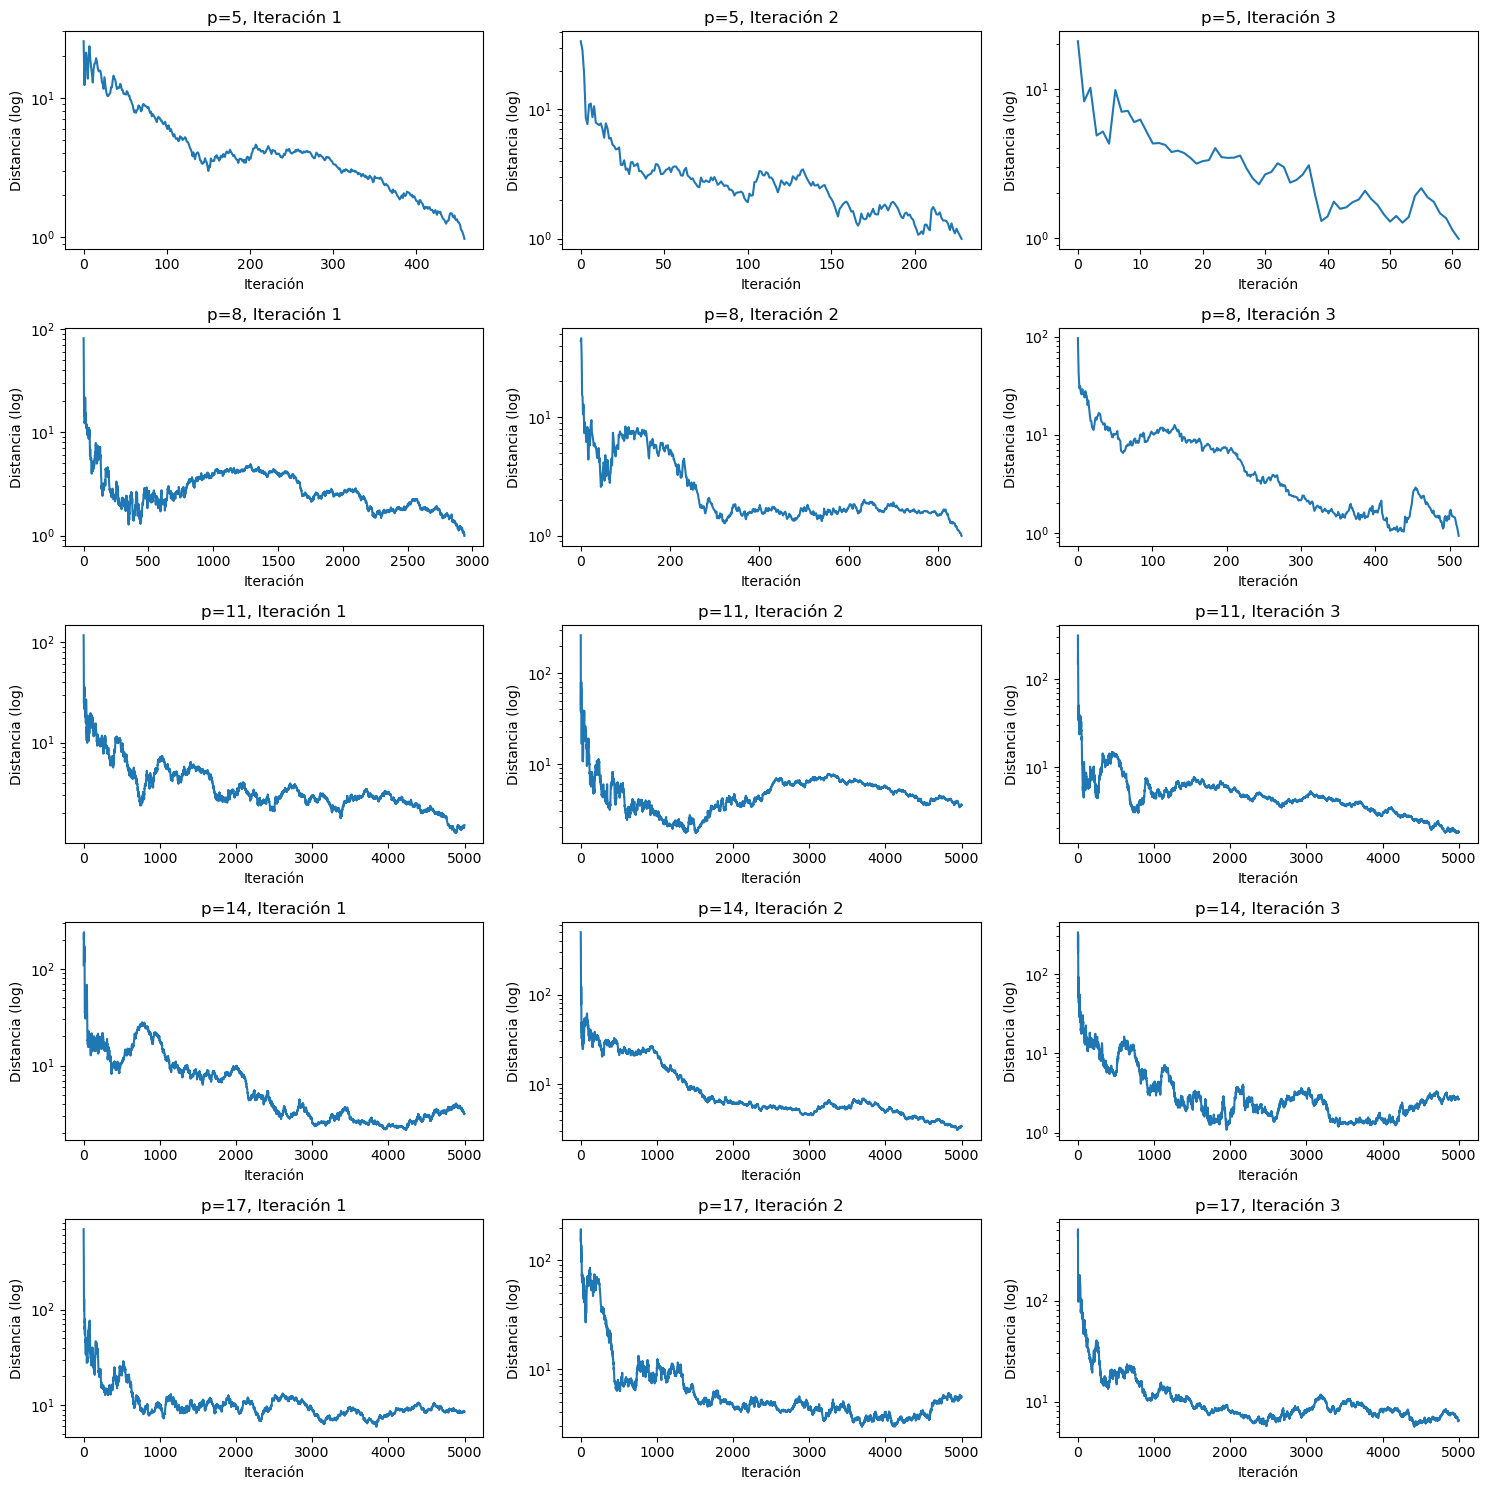

In [79]:
#iterations, distances, lowest_distance = calculate_iterations_to_tolerance(p=p, k=k, tol=tol)
p_list = [5,8,11,14,17]

distances_dic = {}

for p in p_list:
    distances_dic[p] = []

    for _ in range(3):
        iterations, distances, lowest_distance, rechazos = calculate_iterations_to_tolerance(n_max=5_000, p=p, k= p+0.523,tol=1, max_iterations_without_decrease=5_000)
        distances_dic[p].append(distances)
        
# Crear una grilla 5x3 para graficar
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

# Iterar a través de las filas y columnas de la grilla
for i, p in enumerate(p_list):
    for j in range(3):
        distances = distances_dic[p][j]  # Obtener las distancias correspondientes a p y la iteración j
        
        # Graficar las distancias en escala logarítmica
        axs[i, j].semilogy(np.arange(len(distances)), distances)
        axs[i, j].set_title(f'p={p}, Iteración {j+1}')
        axs[i, j].set_xlabel('Iteración')
        axs[i, j].set_ylabel('Distancia (log)')

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [82]:
def calcular_varianzas(matrices):
    # Convertir el array de matrices en un único array tridimensional
    matrices_concatenadas = np.stack(matrices)
    
    # Calcular la varianza en cada posición usando axis=0
    varianzas = np.var(matrices_concatenadas, axis=0)
    
    return varianzas

# Ejemplo de uso:
matrices = [np.array([[1, 1], [1, 1]]), np.array([[1, 2], [3, 4]]), np.array([[1, 3], [5, 7]])]
resultados = calcular_varianzas(matrices)

# Imprimir las varianzas
print(resultados)

[[0.         0.66666667]
 [2.66666667 6.        ]]


In [84]:
def calculate_varianza_teorica(k, Sigma):
    """
    Calcula una matriz donde cada entrada es de la forma k(\sigma_{ij}^2 + \sigma_{ii}\sigma_{jj}).

    Parámetros:
    k (float): El valor k.
    matriz_sigma (numpy.ndarray): La matriz sigma de entrada.

    Retorna:
    numpy.ndarray: La matriz calculada según la fórmula.
    """
    # Obtener las dimensiones de la matriz sigma
    n, m = Sigma.shape
    
    # Crear una matriz vacía con las mismas dimensiones
    matriz_resultado = np.empty_like(Sigma)
    
    # Calcular cada entrada de la matriz resultado
    for i in range(n):
        for j in range(m):
            matriz_resultado[i, j] = k * (Sigma[i, j]**2 + Sigma[i, i] * Sigma[j, j])
    
    return matriz_resultado

# Ejemplo de uso:
k = 2.5  # Valor de k
matriz_sigma = np.array([[1.0, 0.5], [0.5, 2.0]])  # Matriz sigma de ejemplo

matriz_varianza_teorica = calculate_varianza_teorica(k, matriz_sigma)

# Imprimir la matriz de varianza teórica
print(matriz_varianza_teorica)

[[ 5.     5.625]
 [ 5.625 20.   ]]


In [88]:
# Definir los parámetros
p = 4  # Dimensión de la matriz
k = 3.542  # Parámetro k
Sigma = generate_covariance_matrix(p)

M = find_M(p, k, Sigma)

# Número de realizaciones
n_realizaciones = 10_000

# Generar un array de 100 realizaciones
realizaciones = np.empty(n_realizaciones, dtype=object)
for i in range(n_realizaciones):
    realizaciones[i], _ = simulate_wishart_distribution(p, k, Sigma)

varianza_calculada = calcular_varianzas(realizaciones)

varianza_teorica = calculate_varianza_teorica(k, Sigma)

# Imprimir en formato LaTeX
print(r'\textbf{Varianza teórica:}')
print(r'$$')
print(r'\begin{bmatrix}')
for row in varianza_teorica:
    row_str = ' & '.join([f'{val:.2f}' for val in row])
    print(row_str + r' \\')
print(r'\end{bmatrix}')
print(r'$$')

print(r'\textbf{Varianza calculada:}')
print(r'$$')
print(r'\begin{bmatrix}')
for row in varianza_calculada:
    row_str = ' & '.join([f'{val:.2f}' for val in row])
    print(row_str + r' \\')
print(r'\end{bmatrix}')
print(r'$$')

print(r'\textbf{Distancia entre ambas:}')
print(r'$' + str(np.linalg.norm(varianza_calculada - varianza_teorica)) + r'$')

\textbf{Varianza teórica:}
$$
\begin{bmatrix}
15.73 & 17.64 & 14.00 & 8.94 \\
17.64 & 39.75 & 21.87 & 12.98 \\
14.00 & 21.87 & 19.52 & 9.25 \\
8.94 & 12.98 & 9.25 & 5.68 \\
\end{bmatrix}
$$
\textbf{Varianza calculada:}
$$
\begin{bmatrix}
15.68 & 17.86 & 14.06 & 8.96 \\
17.86 & 40.72 & 22.39 & 13.19 \\
14.06 & 22.39 & 20.08 & 9.37 \\
8.96 & 13.19 & 9.37 & 5.72 \\
\end{bmatrix}
$$
\textbf{Distancia entre ambas:}
$1.4312749285053852$
